# Employing Feed Forward Neural Network Model

### Install and import necessary packages

In [1]:
# install ucimlrepo
!pip install ucimlrepo

In [2]:
# import necessary packages
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from ucimlrepo import fetch_ucirepo


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-12-10 23:24:23.105348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing data

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# drop some of the columns
X = X.drop(columns=['odor', 'stalk-root', 'ring-type', 'spore-print-color', 'population', 'habitat'])

### Split into train and test sets

In [4]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# view the shape for X_train, y_train, X_test, and y_test
print('X train:', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train: (6499, 16)
y train (6499, 1)
X test (1625, 16)
y test (1625, 1)


### One-hot encode the features

In [5]:
# one-hot encode the categorical variables in the dataset
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
y_train_encoded = y_train['poisonous'].apply(lambda p: 1 if p=='p' else 0).to_numpy()
X_train_encoded.shape, y_train_encoded.shape

((6499, 76), (6499,))

### Train the model

In [6]:
# build the feed forward model
def build_model(
    hidden_layer_sizes=[],
    dropout_rates=[],
    activation='relu',
    learning_rate=0.01,
    metric='accuracy'
):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    # Set input shape in advance
    model.add(tf.keras.Input(shape=(76,), name='Input'))

    for i, (hidden_layer_size, dropout_rate) in enumerate(zip(hidden_layer_sizes, dropout_rates)):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                      activation=activation,
                                      name=f'Hidden_{i}', use_bias=True))
      model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i}'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', metrics=[metric],optimizer=optimizer)

    return model


### Hyperparameter tuning

In [7]:
# conduct hyperparameter tuning

# determine layers grid
layers_grid = [
    [256],
    [256, 128],
    [256, 256, 128],
    [256, 256, 128, 128],
    [256, 256, 128, 128, 128, 64, 32]
]

# determine droput rates grid
dropout_rates_grid = [
    [0],
    [0.5],
    [0.5, 0.3],
    [0.5, 0.3, 0.2],
    [0.5, 0.3, 0.2, 0.1],
    [0.5, 0.3, 0.2, 0.1, 0.1],
    [0.5, 0.3, 0.2, 0.1, 0.1, 0, 0]
]

# determine learning rates
learning_rates = [0.01, 0.001]

# set initial best values
best_validation_accuracy = 0
best_hidden_layer_sizes = None
best_dropout_rates = None
best_learning_rate = None

# iterate through layers and dropouts and fit a model for each one
for hidden_layer_sizes, dropout_rates in zip(layers_grid, dropout_rates_grid):
  for learning_rate in learning_rates:
    model = build_model(
      hidden_layer_sizes=hidden_layer_sizes,
      dropout_rates=dropout_rates,
      activation='relu',
      learning_rate=0.01,
      metric='accuracy',
    )

    history = model.fit(
      x=X_train_encoded,
      y=y_train_encoded,
      epochs=5,
      batch_size=64,
      validation_split=0.1,
      verbose=0
    )

    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_validation_accuracy:
      best_validation_accuracy = val_accuracy
      best_hidden_layer_sizes = hidden_layer_sizes
      best_dropout_rates = dropout_rates
      best_learning_rate = learning_rate

# show the best hidden layer size, dropout rate, and learning rate
print('Best hidden layer sizes:',best_hidden_layer_sizes)
print('Best dropout rates:',best_dropout_rates)
print('Best learning rate:',best_learning_rate)

Best hidden layer sizes: [256]
Best dropout rates: [0]
Best learning rate: 0.001


### Evaluate best model

In [8]:
# build the best model using the parameters determined above
hidden_layer_sizes = best_hidden_layer_sizes
dropout_rates = best_dropout_rates
model = build_model(
    hidden_layer_sizes=hidden_layer_sizes,
    dropout_rates=dropout_rates,
    activation='relu',
    learning_rate=best_learning_rate,
    metric='accuracy',
)

history = model.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    # verbose=0
)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8476 - loss: 0.4051 - val_accuracy: 0.9508 - val_loss: 0.1426
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.1061 - val_accuracy: 0.9615 - val_loss: 0.0947
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0665 - val_accuracy: 0.9769 - val_loss: 0.0692
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0464 - val_accuracy: 0.9815 - val_loss: 0.0520
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0341 - val_accuracy: 0.9846 - val_loss: 0.0399
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0259 - val_accuracy: 0.9908 - val_loss: 0.0313
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0203 - val_accuracy: 0.9892 - val_loss: 0.0253
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0162 - val_accuracy: 0.9938 - val_loss:

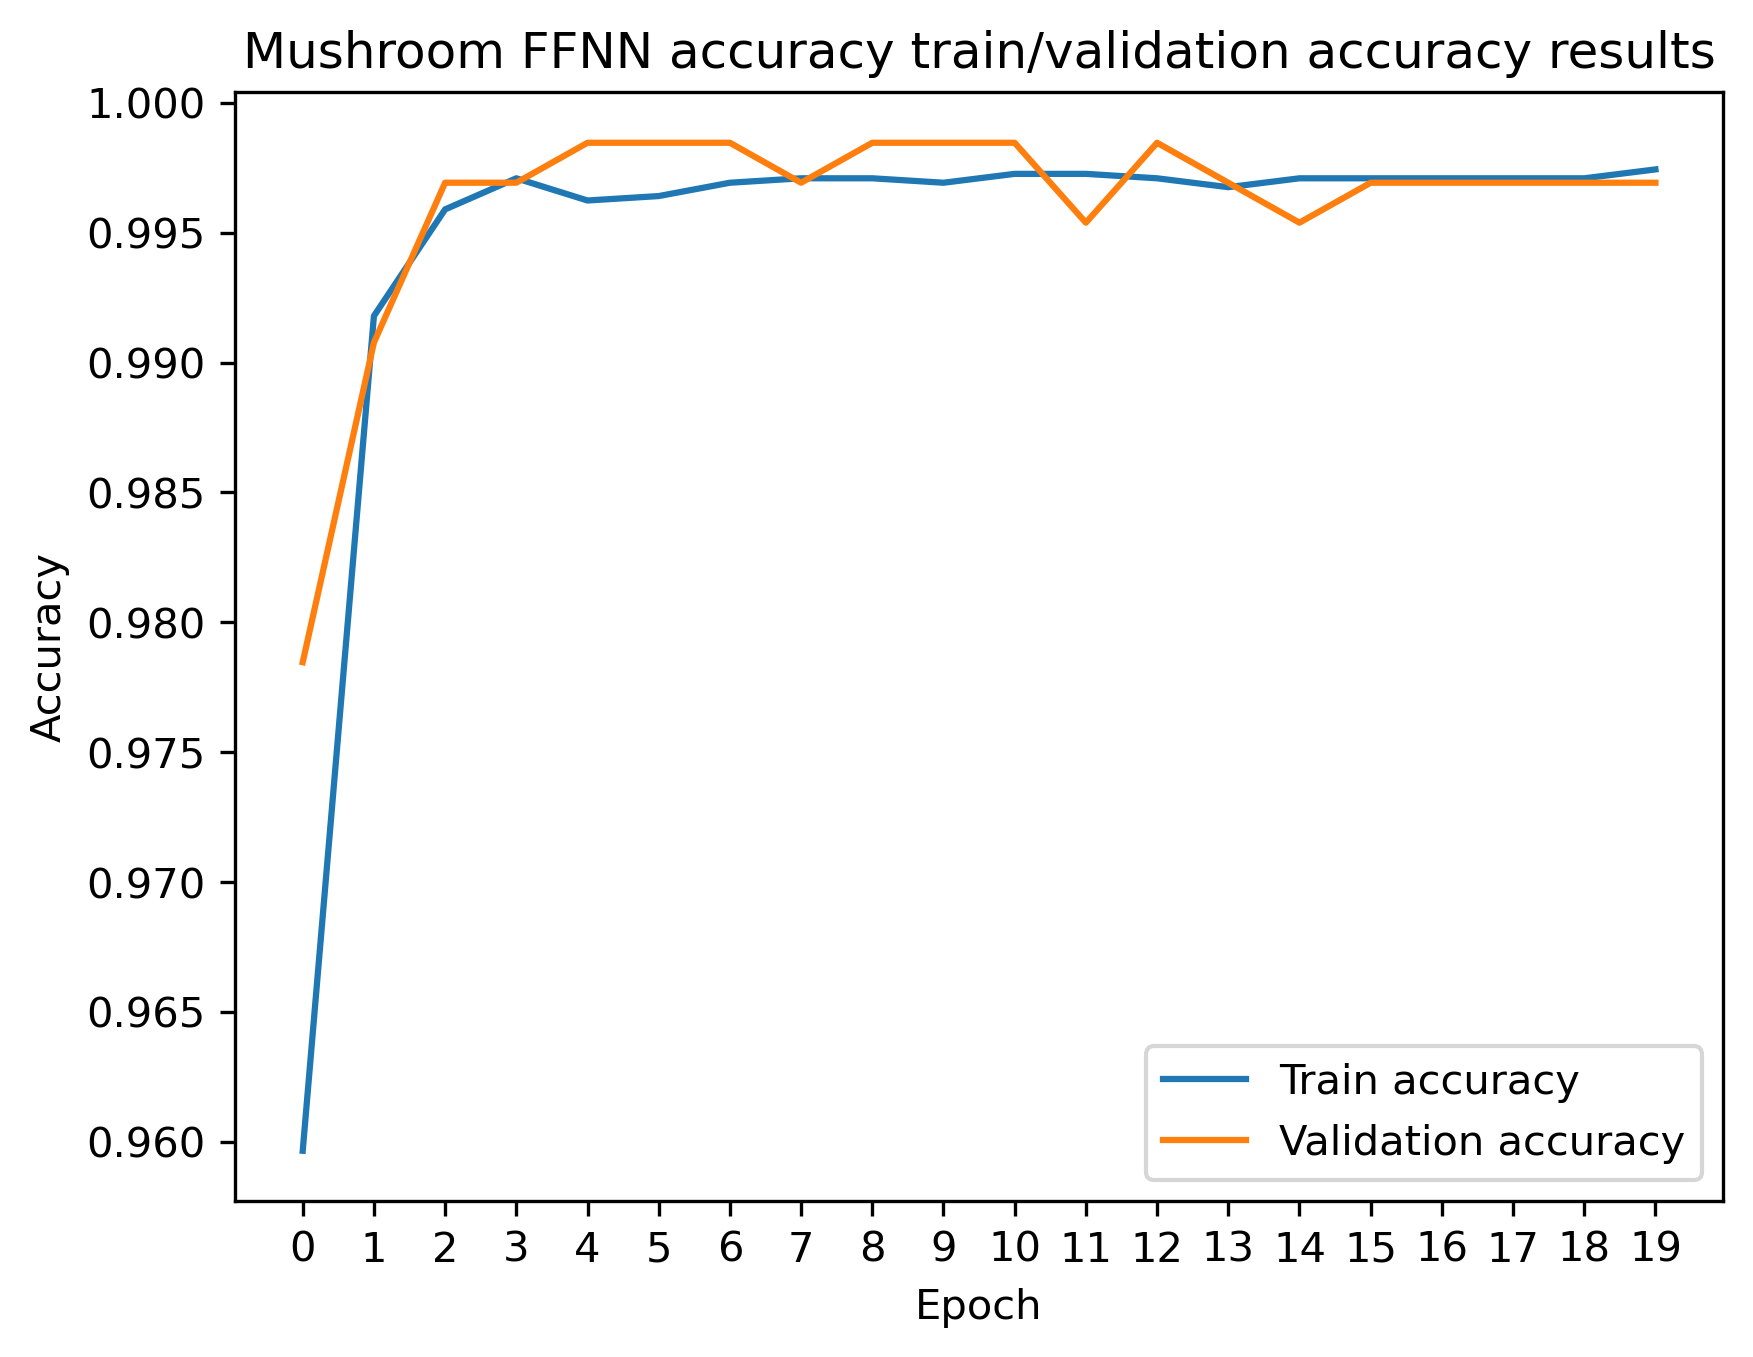

Training accuracy: 0.9974
Validation accuracy: 0.9969


In [9]:
# determine the train and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# plot the accuracy for train and validation
fig, ax = plt.subplots(dpi=300)
ax.plot(train_accuracy, label='Train accuracy')
ax.plot(val_accuracy, label='Validation accuracy')
plt.xticks(range(20))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mushroom FFNN accuracy train/validation accuracy results')
plt.legend()
plt.show()

# show the train and validation accuracy
print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

In [9]:
# Make predictions on the test set
X_test_encoded = encoder.transform(X_test)
y_test_encoded = y_test['poisonous'].apply(lambda p: 1 if p=='p' else 0).to_numpy()

y_pred = model.predict(X_test_encoded)
y_pred_labels = (y_pred > 0.25).astype(int)
y_pred_labels


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

FFNN:
Accuracy: 0.9975
Precision: 0.9949
Recall: 1.0000
F1 Score: 0.9974


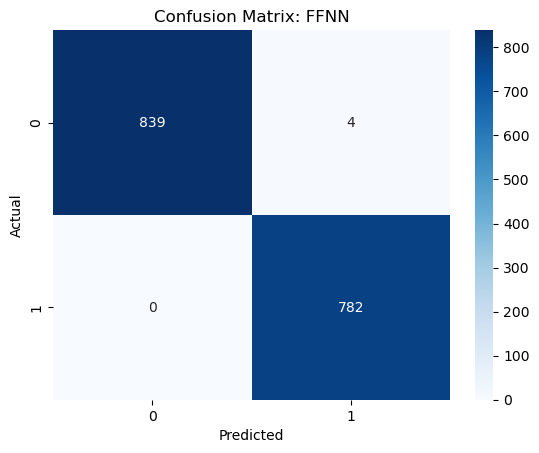

In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_test_encoded, y_pred_labels)
recall = recall_score(y_test_encoded, y_pred_labels)
f1 = f1_score(y_test_encoded, y_pred_labels)

# show the accuracy, precision, recall, and F1 score
print(f"FFNN:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# plot confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: FFNN")
plt.show()

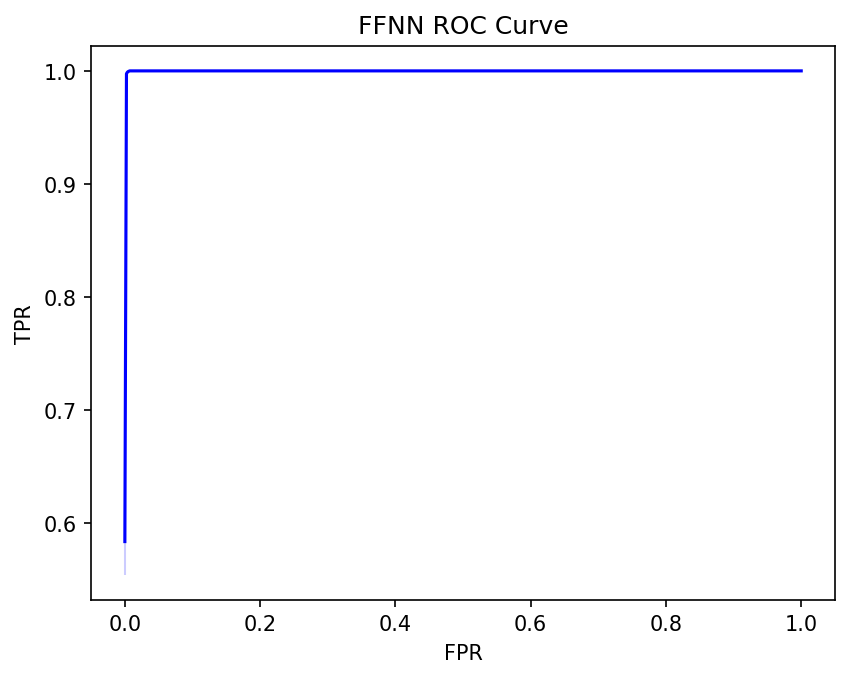

In [11]:
# determine metrics for roc curve
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, y_pred)
auc = metrics.roc_auc_score(y_test_encoded, y_pred)

# plot roc curve
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr, y=tpr, color='blue', ax=ax)
ax.set_title('FFNN ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

plt.show()